In [189]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load files

In [190]:
base_path = "/root/"

dt_train = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

In [191]:
extra_data_path = '/root/extra_data/'

### values needed from dt_train before merge

In [192]:
dt_train['구'] = dt_train['시군구'].map(lambda x : x.split()[1])
dt_train['동'] = dt_train['시군구'].map(lambda x : x.split()[2])
# del dt_train['시군구']

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
# del dt_test['시군구']

In [193]:
dt_train = dt_train[dt_train['계약년월']>=201501]
dt_test = dt_test[dt_test['계약년월']>=201501]

In [194]:
dt_train_over2020 = dt_train[dt_train['계약년월']>=202001]

In [195]:
mean_val_by_gu = dt_train_over2020.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt_train_over2020.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt_train_over2020.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt_train_over2020.groupby("동")["target"].std().sort_values(ascending=False)

### Load Table from pickle

In [196]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

In [197]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'date'],
      dtype='object')

In [198]:
df = df[df['계약년월']>=201501]

### concat to process

In [199]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1

In [200]:
dt = pd.concat([dt_train, dt_test])

In [201]:
dt['is_test'].value_counts()

0    636736
1      9272
Name: is_test, dtype: int64

In [202]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [203]:
dt = dt.reset_index()

In [204]:
df['동'] = dt['동']

### 구 동 encoding of df

In [205]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [206]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [207]:
df['is_public'] = dt["k-전용면적별세대현황(60㎡이하)"].notnull()

### 년도에따라 동, 구별 statistics 추가

In [208]:
# df.drop(['아파트명'], axis=1, inplace=True)

In [209]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [210]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [211]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [212]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [213]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

### yrs_diff 에따른 통계량 추가

In [163]:
# stats = df.groupby(['yrs_diff', '구'])['target'].agg(['std', 'mean', 'max'])
# df = df.join(stats, on=['yrs_diff', '구'], rsuffix='_target')

In [164]:
# df['yrs_diff와구에따른std'] = df['std']
# df['yrs_diff와구에따른mean'] = df['mean']
# df['yrs_diff와구에따른max'] = df['max']
# df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [165]:
# stats = df.groupby(['yrs_diff', '동'])['target'].agg(['std', 'mean', 'max'])
# df = df.join(stats, on=['yrs_diff', '동'], rsuffix='_target')

In [166]:
# df['yrs_diff와동에따른std'] = df['std']
# df['yrs_diff와동에따른mean'] = df['mean']
# df['yrs_diff와동에따른max'] = df['max']
# df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [167]:
# # '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# # '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
# df['yrs_diff와동에따른std'] = df['yrs_diff와동에따른std'].fillna(df['yrs_diff와구에따른std'])
# df['yrs_diff와동에따른mean'] = df['yrs_diff와동에따른mean'].fillna(df['yrs_diff와구에따른mean'])
# df['yrs_diff와동에따른max'] = df['yrs_diff와동에따른max'].fillna(df['yrs_diff와구에따른max'])

In [214]:
df.drop(['동', 'large_std_동', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

### KOSPI 종가 delay

In [215]:
# # Use glob to find all files that match the pattern
# file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# # Initialize an empty list to store the dataframes
# dfs = []

# # Iterate over the file paths and read each CSV file into a dataframe
# for file_path in file_paths:
#     kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
#     dfs.append(kospi_df_yr)

# kospi_df = pd.concat(dfs, ignore_index=True)
# kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [216]:
# kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
# kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
# kospi_df["date"] = pd.to_datetime(kospi_df["date"])
# kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [217]:
# kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [218]:
# df.columns

In [219]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [220]:
# df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [221]:
# df.drop(columns=['Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [222]:
# df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [223]:
df['date'] = df['date'].astype(str)

In [225]:
df.drop(['구', '구_std', '동_std', '계약년월', '계약년', '계약월', '계약일'], axis=1, inplace=True)

### 면적당단가 적용

In [226]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', 'date', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'],
      dtype='object')

In [227]:
df['ann_price_per_area'] = df['평균공시가격'] / df['전용면적(㎡)']

In [228]:
df['ann_price_per_area'].isnull().sum()

0

In [229]:
df['target_price_per_area'] = df['target'] / df['전용면적(㎡)']

In [230]:
df['target_price_per_area'].isnull().sum()

9272

In [231]:
# Sort the DataFrame by '도로명', '전용면적', and any relevant time column (if available)
df_sorted = df.sort_values(by=['도로명', '전용면적(㎡)', 'date'], ascending=True)

# Forward fill missing values in 'price_per_area' based on '도로명' and '전용면적'
df['target_price_per_area'] = df_sorted.groupby(['도로명', '전용면적(㎡)'])['target_price_per_area'].ffill()

# If there are any remaining missing values after forward fill, you can backfill them
df['target_price_per_area'] = df['target_price_per_area'].bfill()

In [232]:
df['target_price_per_area'].isnull().sum()

0

In [233]:
df['over_240'] = df['전용면적(㎡)'].apply(lambda x: 1 if x > 240 else 0)

In [234]:
df['over_240'].value_counts()

0    645029
1       979
Name: over_240, dtype: int64

In [235]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', 'date', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'ann_price_per_area',
       'target_price_per_area', 'over_240'],
      dtype='object')

In [236]:
df['maxfl'] = df_sorted.groupby('아파트명')['층'].transform('max')
df['is_maxfl'] = (df['층'] == df['maxfl']).astype(int)

In [237]:
df['is_maxfl'].value_counts()

0    618907
1     27101
Name: is_maxfl, dtype: int64

In [238]:
del df['maxfl']

### Feature Engineering

### Train

In [239]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 20) (9272, 20)


In [240]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '평균공시가격', '구_encoded', '동_encoded', 'yrs_diff', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'ann_price_per_area', 'target_price_per_area', 'over_240', 'is_maxfl']
범주형 변수: ['번지', '아파트명', '도로명', 'date', 'is_public']


In [241]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


In [242]:
df_train0 = df_train[(df_train['전용면적(㎡)']<60)]
df_train60 = df_train[(df_train['전용면적(㎡)']>=60)&(df_train['전용면적(㎡)']<135)]
df_train135 = df_train[(df_train['전용면적(㎡)']>=135)]

In [243]:
X_test = df_test.drop(['target'], axis=1)
# X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

X_test
X_test0 = X_test[(X_test['전용면적(㎡)']<60)]
X_test60 = X_test[(X_test['전용면적(㎡)']>=60)&(X_test['전용면적(㎡)']<135)]
X_test135 = X_test[(X_test['전용면적(㎡)']>=135)]

In [244]:
y_train0 = df_train0['target']
X_train0 = df_train0.drop(['target'], axis=1)


y_train60 = df_train60['target']
X_train60 = df_train60.drop(['target'], axis=1)

y_train135 = df_train135['target']
X_train135 = df_train135.drop(['target'], axis=1)

In [245]:
X_train0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       '구_encoded', '동_encoded', 'yrs_diff', 'is_public', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'ann_price_per_area',
       'target_price_per_area', 'over_240', 'is_maxfl'],
      dtype='object')

In [246]:
drop_col_under135 = ['target_price_per_area', 'over_240', 'is_maxfl']
drop_col_over135 = ['ann_price_per_area', 'is_public', 'date']

In [247]:
X_train0.drop(columns=drop_col_under135, inplace=True)
X_test0.drop(columns=drop_col_under135, inplace=True)
X_train60.drop(columns=drop_col_under135, inplace=True)
X_test60.drop(columns=drop_col_under135, inplace=True)

In [248]:
# Split the data into train and validation sets
X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
X_train60, X_val60, y_train60, y_val60 = train_test_split(X_train60, y_train60, test_size=0.2, random_state=2023)

In [249]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 16) (49004, 16)
(291853, 16) (72964, 16)


In [250]:
X_train0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       '구_encoded', '동_encoded', 'yrs_diff', 'is_public', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'ann_price_per_area'],
      dtype='object')

In [251]:
gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=30,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)



gbm60 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=600, min_child_samples=30,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

In [252]:
gbm0.fit(
        X_train0, y_train0, 
        eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2513.6	training's l2: 6.31817e+06	valid_1's rmse: 3573.6	valid_1's l2: 1.27707e+07
[200]	training's rmse: 2070.09	training's l2: 4.28525e+06	valid_1's rmse: 3432.71	valid_1's l2: 1.17835e+07
[300]	training's rmse: 1844.68	training's l2: 3.40285e+06	valid_1's rmse: 3395.29	valid_1's l2: 1.1528e+07
[400]	training's rmse: 1685.86	training's l2: 2.84211e+06	valid_1's rmse: 3382.86	valid_1's l2: 1.14437e+07
Early stopping, best iteration is:
[440]	training's rmse: 1628.9	training's l2: 2.6533e+06	valid_1's rmse: 3380.91	valid_1's l2: 1.14306e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=600,
              verbosity=-1)

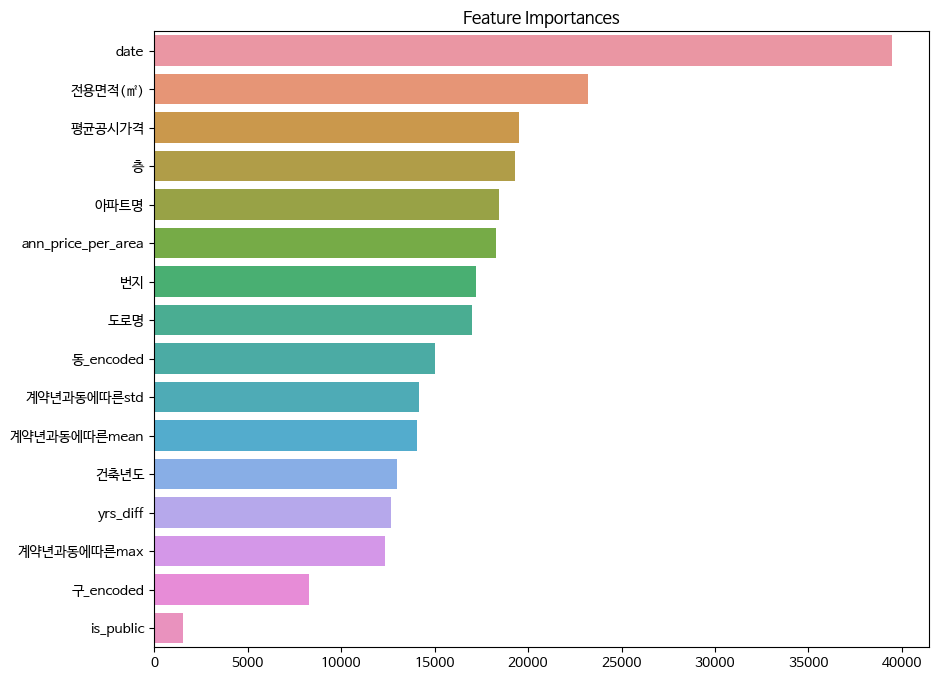

In [253]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm0.feature_importances_, index=list(X_train0.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [254]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm0,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val0, y_val0)
eli5.show_weights(perm, feature_names = X_val0.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
590937396.3301 ± 2132799.3462,평균공시가격
447965768.5200 ± 4167416.0117,date
110498382.2933 ± 1886276.2798,전용면적(㎡)
32705343.7983 ± 305307.4566,구_encoded
25930973.2126 ± 396463.5482,건축년도
14020776.1774 ± 201142.9235,ann_price_per_area
7054352.7477 ± 110870.7238,yrs_diff
6700696.8432 ± 279790.3323,계약년과동에따른mean
6218255.0697 ± 210422.6597,아파트명
5181773.5721 ± 103808.9619,도로명


In [255]:
gbm60.fit(
        X_train60, y_train60, 
        eval_set=[(X_train60, y_train60), (X_val60, y_val60)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4570.92	training's l2: 2.08933e+07	valid_1's rmse: 5930.4	valid_1's l2: 3.51697e+07
[200]	training's rmse: 3756.59	training's l2: 1.4112e+07	valid_1's rmse: 5576.96	valid_1's l2: 3.11024e+07
[300]	training's rmse: 3348.55	training's l2: 1.12128e+07	valid_1's rmse: 5481.5	valid_1's l2: 3.00468e+07
[400]	training's rmse: 3072.75	training's l2: 9.44181e+06	valid_1's rmse: 5434.9	valid_1's l2: 2.95381e+07
[500]	training's rmse: 2846.17	training's l2: 8.10071e+06	valid_1's rmse: 5417.22	valid_1's l2: 2.93463e+07
[600]	training's rmse: 2667.68	training's l2: 7.11652e+06	valid_1's rmse: 5410.81	valid_1's l2: 2.92769e+07
Early stopping, best iteration is:
[573]	training's rmse: 2719.33	training's l2: 7.39474e+06	valid_1's rmse: 5408.53	valid_1's l2: 2.92521e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=600,
              verbosity=-1)

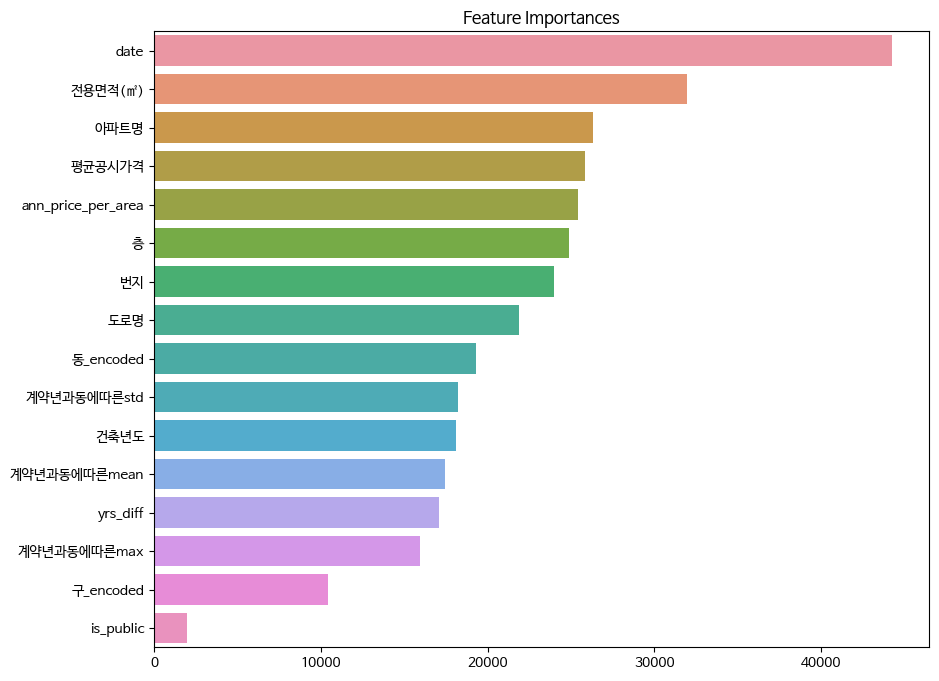

In [256]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm60.feature_importances_, index=list(X_train60.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [257]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm60,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val60, y_val60)
eli5.show_weights(perm, feature_names = X_val60.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1385897224.6333 ± 7355499.0814,평균공시가격
977158830.0389 ± 6112606.1310,date
137347396.7667 ± 4047546.4305,전용면적(㎡)
85721254.8003 ± 1065359.2321,구_encoded
67341107.2294 ± 1728992.1759,건축년도
24524926.6948 ± 637353.1836,ann_price_per_area
17863878.6116 ± 695172.0276,도로명
16041899.0565 ± 314954.3667,번지
15304792.8397 ± 549755.5094,계약년과동에따른mean
13781516.0171 ± 327239.7124,yrs_diff


### 135만 다르게 접근해야할 것 같음

In [258]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 16) (49004, 16)
(291853, 16) (72964, 16)


In [259]:
X_train135.drop(columns=drop_col_over135, inplace=True)

In [260]:
X_test135.drop(columns=drop_col_over135, inplace=True)

In [261]:
X_train135.shape

(26900, 16)

In [262]:
# X_train135, X_val135

In [263]:
from sklearn.model_selection import KFold, cross_val_score

In [264]:
# Define the number of base learners for the ensemble
num_base_learners = 5

# Initialize an empty list to store the base learners
base_learners = []

num_folds = 5
# Define the k-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2023)

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train135), 1):
    print(f"Fold {fold}/{num_folds}")
    X_train_fold, X_val_fold = X_train135.iloc[train_idx], X_train135.iloc[val_idx]
    y_train_fold, y_val_fold = y_train135.iloc[train_idx], y_train135.iloc[val_idx]
    
    # Initialize a LightGBM regressor for the base learner
    gbm135 = lgb.LGBMRegressor(n_estimators=5000, max_depth=20, num_leaves=600, min_child_samples=10,
                            feature_fraction=0.7, bagging_fraction=0.9, verbosity=-1)
    
    # Train the base learner
    gbm135.fit(
            X_train_fold, y_train_fold, 
            eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)], 
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=100, show_stdv=True)]
            )
    
    # Add the trained base learner to the list
    base_learners.append(gbm135)

# Initialize an empty array to store predictions from each base learner
predictions = np.zeros(len(X_train135))

# Make predictions using each base learner and aggregate them
for gbm in base_learners:
    predictions += gbm.predict(X_train135)

# Take the average of the predictions to get the final prediction
ensemble_prediction = predictions / num_base_learners

Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2361.87	training's l2: 5.57841e+06	valid_1's rmse: 8410.7	valid_1's l2: 7.074e+07
[200]	training's rmse: 1204.46	training's l2: 1.45072e+06	valid_1's rmse: 8204.2	valid_1's l2: 6.73089e+07
[300]	training's rmse: 783.382	training's l2: 613687	valid_1's rmse: 8185.09	valid_1's l2: 6.69957e+07
Early stopping, best iteration is:
[292]	training's rmse: 814.108	training's l2: 662771	valid_1's rmse: 8181.64	valid_1's l2: 6.69392e+07
Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2080.73	training's l2: 4.32944e+06	valid_1's rmse: 10347	valid_1's l2: 1.0706e+08
[200]	training's rmse: 1134.6	training's l2: 1.28731e+06	valid_1's rmse: 10042	valid_1's l2: 1.00841e+08
[300]	training's rmse: 809.633	training's l2: 655506	valid_1's rmse: 9997.72	valid_1's l2: 9.99545e+07
[400]	training's rmse: 638.626	training's l2: 407844	valid_1's rmse: 9969.13	valid_1's l2: 9.9

In [265]:
ensemble_prediction.max()

1391519.1570267342

In [266]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred60 = gbm60.predict(X_test60)

In [267]:
X_test0['target'] = real_test_pred0
X_test60['target'] = real_test_pred60

In [268]:
# List to store predictions from base learners
predictions = []

# Iterate over base learners and get predictions for X_test135
for gbm in base_learners:
    predictions.append(gbm.predict(X_test135))

# Convert predictions to a NumPy array
predictions_array = np.array(predictions)

# Take the maximum prediction across the base learners
max_predictions = np.max(predictions_array, axis=0)

# Fill X_test135['target'] with the maximum predictions
X_test135['target'] = max_predictions


In [269]:
X_test135['target'].describe().round(2)

count        357.00
mean      285890.50
std       162652.53
min        42793.38
25%       178947.06
50%       254580.24
75%       348578.80
max      1259777.23
Name: target, dtype: float64

In [270]:
X_test0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       '구_encoded', '동_encoded', 'yrs_diff', 'is_public', '계약년과동에따른std',
       '계약년과동에따른mean', '계약년과동에따른max', 'ann_price_per_area', 'target'],
      dtype='object')

In [271]:
X_test135.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', '구_encoded',
       '동_encoded', 'yrs_diff', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max',
       'target_price_per_area', 'over_240', 'is_maxfl', 'target'],
      dtype='object')

In [272]:
X_test0.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test60.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test135.drop(['target_price_per_area', 'over_240', 'is_maxfl'], axis=1, inplace=True)

In [273]:
# concat

concat_test = pd.concat([X_test0, X_test60, X_test135], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,아파트명,전용면적(㎡),층,건축년도,도로명,평균공시가격,구_encoded,동_encoded,yrs_diff,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,target
1118822,4682,319,79.9700,5,1987,6025,120960.000000,0,NaN,36,112520.254068,208005.081699,900000.0,172805.210198
1118823,4657,320,108.2017,10,2021,464,155775.000000,0,NaN,2,112520.254068,208005.081699,900000.0,257470.886158
1118824,4658,324,161.0000,15,1984,462,182537.777778,0,NaN,39,112520.254068,208005.081699,900000.0,358742.949075
1118825,4658,324,133.4600,14,1984,462,182537.777778,0,NaN,39,112520.254068,208005.081699,900000.0,267478.784565
1118826,4658,324,104.4300,6,1984,462,182537.777778,0,NaN,39,112520.254068,208005.081699,900000.0,200579.634965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,5716,3617,84.6500,13,2014,5423,39021.326676,22,NaN,9,27142.558383,56865.823529,185000.0,67681.107344
1128090,5716,3617,84.6200,12,2014,5423,39021.326676,22,NaN,9,27142.558383,56865.823529,185000.0,68102.884189
1128091,5716,3617,101.6500,12,2014,5423,39021.326676,22,NaN,9,27142.558383,56865.823529,185000.0,82654.824374
1128092,5716,3617,84.9400,18,2014,5423,39021.326676,22,NaN,9,27142.558383,56865.823529,185000.0,67485.185353


In [276]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_0401_2pm_yoon.csv', index=False)



In [275]:
preds_df2.describe().round(2)

,target
count,9272.00
mean,105185.85
std,74000.81
min,8433.00
25%,62112.25
50%,87038.50
75%,123577.75
max,1259777.00
